# EDA

In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import snscrape.modules.twitter as sntwitter
from pathlib import Path  
import re
import string
from transformers import AutoTokenizer
#add package
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [163]:
# requirements 
# wordcloud
# scipy
# transformers
# tqdm
# matplotlib
# nltk

In [164]:
vaccine_df_2020_2021 = pd.read_csv(r'data/vaccine_output_2020_2021.csv')

#vaccine_df_2021_2022 = pd.read_csv(r'data/vaccine_output_2021_2022.csv')

In [165]:
vaccine_df_2020_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   Date        10000 non-null  object
 2   User        10000 non-null  object
 3   Tweet       10000 non-null  object
 4   Tweet_URL   10000 non-null  object
 5   Location    7531 non-null   object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [166]:
print(vaccine_df_2020_2021.shape)

(10000, 6)


In [167]:
vaccine_df_2020_2021.head()

,Unnamed: 0,Date,User,Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,https://twitter.com/WebAeneas/status/146835672...,NaN
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


### PREPROCESSING TWEETS

In [168]:
# clean and filter using SPARK
def preprocessing(df):
    location_df = df['Location']
    #tweet_lower_df = df['Tweet'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = df['Tweet'].replace(r'\s+',' ',regex=True)
    tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_emoji_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    #tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)
    
    
    location_whitespace_df =  location_df.replace(r'\s+',' ',regex=True)
    location_hashtag_df = location_whitespace_df.replace(r'#','',regex=True)
    location_numbers_df = location_hashtag_df.replace(r'[0-9]+','',regex=True)
    location_emoji_df = location_numbers_df.replace(EMOJI_PATTERN,'',regex = True)
    PUNCT_MODIFIED = r'[.|!|#|\"|$|%|\'|\(|\)|*|+|=|<|>|~|\{|\}|\\|/|:|;|\?|@|\[|^|_|\`|\]]'
    location_punc_df = location_emoji_df.replace(PUNCT_MODIFIED,'',regex = True)
    return tweet_numbers_df,location_punc_df


In [169]:
vaccine_20_21_cleanedDF = vaccine_df_2020_2021
vaccine_20_21_cleanedDF['Processed_Tweet'],vaccine_20_21_cleanedDF['Location'] = preprocessing(vaccine_df_2020_2021)
vaccine_20_21_cleanedDF['Location'] = vaccine_20_21_cleanedDF['Location'].fillna('')
vaccine_20_21_cleanedDF

,Unnamed: 0,Date,User,Tweet,Tweet_URL,Location,Processed_Tweet
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",COVIDMythBustingTuesdays! Myth: Doesn’t the CO...
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,https://twitter.com/WebAeneas/status/146835672...,,vaccinated another great idea you can sue anyo...
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",https://twitter.com/TheAmirImani/status/146835...,Toronto,"I don't know if this is a "" dose vaccine"" or a..."
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",Can anyone prove that the covid vaccine preven...
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",About people die each day from COVID in the U...
...,...,...,...,...,...,...,...
9995,9995,2021-10-18 19:56:53+00:00,Kai_The_Dogeer,Going for my first part of the #covid shot. X....,https://twitter.com/Kai_The_Dogeer/status/1450...,"Tennessee, USA",Going for my first part of the covid shot. X.x...
9996,9996,2021-10-18 19:35:53+00:00,akroncrackrono1,#yahoo BIASED #news is trying to spin the deat...,https://twitter.com/akroncrackrono1/status/145...,,yahoo BIASED news is trying to spin the death ...
9997,9997,2021-10-18 18:48:02+00:00,SunshineBio1,We are excited to highlight that $SBFM is now ...,https://twitter.com/SunshineBio1/status/145017...,,We are excited to highlight that $SBFM is now ...
9998,9998,2021-10-18 18:48:01+00:00,cr8f,That damn #CovidVaccine does a shitty job on c...,https://twitter.com/cr8f/status/14501718286899...,"Born in WI, moved to Oregon",That damn CovidVaccine does a shitty job on ca...


In [170]:
#Rearrange columns
col_list = vaccine_20_21_cleanedDF.columns.tolist()
cols = col_list[:-3] + col_list[-1:] + col_list[4:6]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF[cols]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF.rename({'Unnamed: 0': 'ID'}, axis=1) 
vaccine_20_21_cleanedDF.columns.tolist()


['ID', 'Date', 'User', 'Tweet', 'Processed_Tweet', 'Tweet_URL', 'Location']

In [171]:
vaccine_20_21_cleanedDF.to_csv(r'data/new_processed.csv', encoding='utf-8')

In [172]:
vaccine_20_21_cleanedDF.head()

,ID,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


(-0.5, 399.5, 199.5, -0.5)

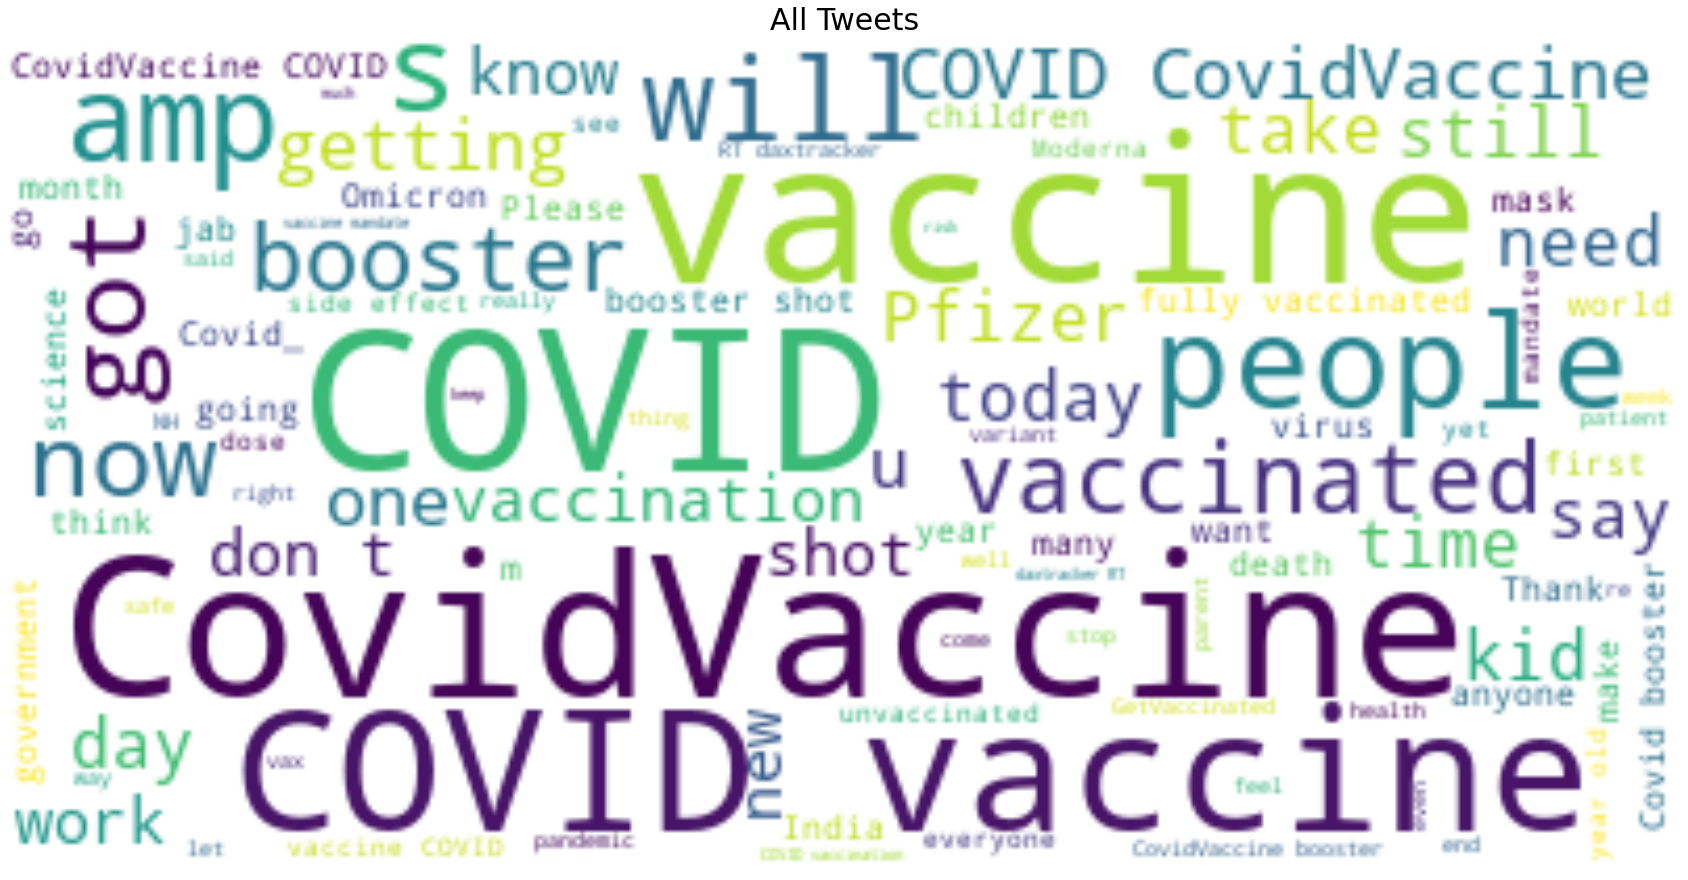

In [173]:

tweet_All = " ".join(review for review in vaccine_20_21_cleanedDF['Processed_Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')


The Most Frequent words are 'CovidVaccine , Covid , Virus , Omicron ' Occurs almost in all the sentances , this along with the stop words wouldnt affect the performance of algorithms but words like Pfizer Moderna can help us determine the popular vaccine , and words such as "side effect  , death " can help us tag misinformed tweets about covid vaccine 

## ALGORITHMS

#### Basic NLTK Operations

In [174]:
sample = vaccine_20_21_cleanedDF['Processed_Tweet'][200]
print(sample)

#VADER 
#ROBERTA
#Compare and visualize 
#Pipeline for current tweet

Got my CovidVaccine Booster! Please get yours too, if you're able. We all need to do our part to keep our communities safe. GetVaccinated grateful


In [175]:
tokens = nltk.word_tokenize(sample)
print(tokens)

['Got', 'my', 'CovidVaccine', 'Booster', '!', 'Please', 'get', 'yours', 'too', ',', 'if', 'you', "'re", 'able', '.', 'We', 'all', 'need', 'to', 'do', 'our', 'part', 'to', 'keep', 'our', 'communities', 'safe', '.', 'GetVaccinated', 'grateful']


In [176]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('Got', 'NNP'), ('my', 'PRP$'), ('CovidVaccine', 'NNP'), ('Booster', 'NNP'), ('!', '.'), ('Please', 'NNP'), ('get', 'VB'), ('yours', 'RB'), ('too', 'RB'), (',', ','), ('if', 'IN'), ('you', 'PRP'), ("'re", 'VBP'), ('able', 'JJ'), ('.', '.'), ('We', 'PRP'), ('all', 'DT'), ('need', 'VBP'), ('to', 'TO'), ('do', 'VB'), ('our', 'PRP$'), ('part', 'NN'), ('to', 'TO'), ('keep', 'VB'), ('our', 'PRP$'), ('communities', 'NNS'), ('safe', 'VBP'), ('.', '.'), ('GetVaccinated', 'VBN'), ('grateful', 'JJ')]


In [177]:
#chunked into a sentance
Chunked_sentence_entities = nltk.chunk.ne_chunk(tagged)
Chunked_sentence_entities.pprint()

(S
  Got/NNP
  my/PRP$
  (ORGANIZATION CovidVaccine/NNP Booster/NNP)
  !/.
  Please/NNP
  get/VB
  yours/RB
  too/RB
  ,/,
  if/IN
  you/PRP
  're/VBP
  able/JJ
  ./.
  We/PRP
  all/DT
  need/VBP
  to/TO
  do/VB
  our/PRP$
  part/NN
  to/TO
  keep/VB
  our/PRP$
  communities/NNS
  safe/VBP
  ./.
  GetVaccinated/VBN
  grateful/JJ)


In [178]:
a = vaccine_20_21_cleanedDF['Tweet'][10]
a

'Just found out that my youngest was exposed to covid last Friday. She’s vaxxed so I’m hoping she doesn’t get it AGAIN, as in a second time. 😩🙏🏻#WearADamnMask #GetVaxxed #CovidVaccine'

In [179]:
b = 'just found out   youngest was exposed   last friday shes  hoping she does not get it again as in a second time wear a damn mask  '
b

'just found out   youngest was exposed   last friday shes  hoping she does not get it again as in a second time wear a damn mask  '

### VADER SENTIMENT SCORING

In [180]:
Sentiment_analyzer = SentimentIntensityAnalyzer()
result = Sentiment_analyzer.polarity_scores(b)
result

{'neg': 0.149, 'neu': 0.746, 'pos': 0.104, 'compound': -0.0516}

In [181]:
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/preethi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [182]:
Sentiment_analyzer = SentimentIntensityAnalyzer()
Vaders_result = {}
for idx,row in tqdm(vaccine_20_21_cleanedDF.iterrows(),total=len(vaccine_20_21_cleanedDF)):
    Processed_Tweet = row['Tweet']
    id = row['ID']
    Vaders_result[id] = Sentiment_analyzer.polarity_scores(Processed_Tweet)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [183]:
Tweet_vaders = pd.DataFrame(Vaders_result).T

In [184]:
Tweet_vaders

,neg,neu,pos,compound
0,0.143,0.746,0.111,-0.3579
1,0.075,0.719,0.206,0.6581
2,0.097,0.813,0.089,-0.1027
3,0.000,0.967,0.033,0.0258
4,0.149,0.744,0.107,-0.4387
...,...,...,...,...
9995,0.136,0.794,0.070,-0.2672
9996,0.312,0.645,0.043,-0.9292
9997,0.000,0.839,0.161,0.5859
9998,0.641,0.359,0.000,-0.8934


In [185]:
Tweet_vaders = Tweet_vaders.reset_index().rename(columns={'index' : 'ID'})
vaccine_20_21_cleanedDF

,ID,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"
...,...,...,...,...,...,...,...
9995,9995,2021-10-18 19:56:53+00:00,Kai_The_Dogeer,Going for my first part of the #covid shot. X....,Going for my first part of the covid shot. X.x...,https://twitter.com/Kai_The_Dogeer/status/1450...,"Tennessee, USA"
9996,9996,2021-10-18 19:35:53+00:00,akroncrackrono1,#yahoo BIASED #news is trying to spin the deat...,yahoo BIASED news is trying to spin the death ...,https://twitter.com/akroncrackrono1/status/145...,
9997,9997,2021-10-18 18:48:02+00:00,SunshineBio1,We are excited to highlight that $SBFM is now ...,We are excited to highlight that $SBFM is now ...,https://twitter.com/SunshineBio1/status/145017...,
9998,9998,2021-10-18 18:48:01+00:00,cr8f,That damn #CovidVaccine does a shitty job on c...,That damn CovidVaccine does a shitty job on ca...,https://twitter.com/cr8f/status/14501718286899...,"Born in WI, moved to Oregon"


In [186]:
Tweet_vaders = Tweet_vaders.merge(vaccine_20_21_cleanedDF,how = 'left')
#we have sentiment score and meta data for each reviews
Tweet_vaders.head()


,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,0.143,0.746,0.111,-0.3579,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,0.097,0.813,0.089,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,0.000,0.967,0.033,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,0.149,0.744,0.107,-0.4387,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


In [202]:
Tweet_vaders['Vader_Sentiment_Score'] =  Tweet_vaders[["neg", "neu","pos"]].max(axis=1)
Tweet_vaders_sentiment = Tweet_vaders
Tweet_vaders_sentiment['Vader_Sentiment'] = Tweet_vaders[["neg", "neu","pos"]].idxmax(axis=1)
Tweet_vaders_sentiment.head()

,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment
0,0,0.143,0.746,0.111,-0.3579,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.746,neu
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu
2,2,0.097,0.813,0.089,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto,0.813,neu
3,3,0.000,0.967,0.033,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.967,neu
4,4,0.149,0.744,0.107,-0.4387,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.744,neu


In [203]:
sentiment_counts = Tweet_vaders_sentiment.groupby(['Vader_Sentiment']).size()
print(sentiment_counts)

Vader_Sentiment
neg      19
neu    9933
pos      48
dtype: int64


<AxesSubplot:>

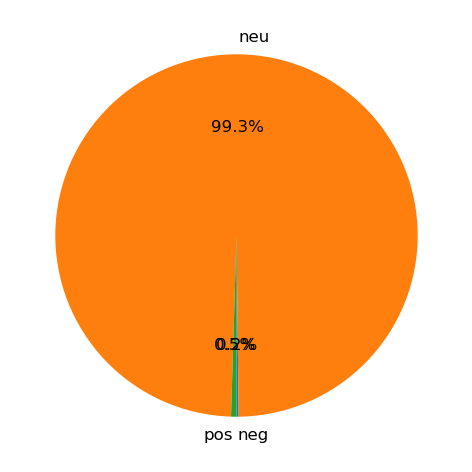

In [204]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [205]:
Tweet_vaders_sentiment.to_csv("data/vader_tweets.csv")

## ROBERTA TRANSFORMERS

In [206]:
#Hugging face - it will pull the model weights that are stored - transfer learning , we don't have to retrain the model at all
#it downloads all of the weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [207]:
#vader results
print(sample)
Sentiment_analyzer.polarity_scores(sample)

Got my CovidVaccine Booster! Please get yours too, if you're able. We all need to do our part to keep our communities safe. GetVaccinated grateful


{'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.8172}

In [208]:
#Run on Roberta Model
#encoding the text
#'pt' - pytorch
encoded_text = tokenizer(sample,return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0, 40084,   127, 19150,   808,   846,  7904,   833, 43996,   328,
          3401,   120, 14314,   350,     6,   114,    47,   214,   441,     4,
           166,    70,   240,     7,   109,    84,   233,     7,   489,    84,
          1822,  1522,     4,  2315,   846,  7904,  9339,  6161,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [209]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-3.0435,  0.6461,  2.3345]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [210]:
scores = output[0][0].detach().numpy()
scores


array([-3.0434713 ,  0.64614516,  2.3344975 ], dtype=float32)

In [211]:
softmax_scores = softmax(scores)
softmax_scores

array([0.00388182, 0.15538712, 0.8407311 ], dtype=float32)

In [212]:
scores_dict = {
    'roberta_neg' : softmax_scores[0],
    'roberta_neu' : softmax_scores[1],
    'roberta_pos' : softmax_scores[2]
}
print(scores_dict)

{'roberta_neg': 0.003881816, 'roberta_neu': 0.15538712, 'roberta_pos': 0.8407311}


In [217]:
Tweet_vaders_sentiment.head()

,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment
0,0,0.143,0.746,0.111,-0.3579,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.746,neu
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu
2,2,0.097,0.813,0.089,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto,0.813,neu
3,3,0.000,0.967,0.033,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.967,neu
4,4,0.149,0.744,0.107,-0.4387,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.744,neu


In [215]:
def roberta_polarity_scores(sample):
    encoded = tokenizer(sample,return_tensors='pt')
    output = model(**encoded)
    scores=output[0][0].detach().numpy()
    softmax_scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : softmax_scores[0],
        'roberta_neu' : softmax_scores[1],
        'roberta_pos' : softmax_scores[2]
    }
    return scores_dict


In [216]:
#iterate over the dataset to calculate scores for each example
# some size of the text is too big for the roberta model to handle , we can skip those by adding try
result = {}
for i,row in tqdm(Tweet_vaders_sentiment.iterrows(),total=len(Tweet_vaders_sentiment)):
    try:
        tweet = row['Tweet']
        id = row['ID']
        vader_result = Sentiment_analyzer.polarity_scores(tweet)
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = roberta_polarity_scores(tweet)
        #combining two dictionaries
        combined_result = {**vader_result,**roberta_result}
        #break
        result[id] = combined_result
    except RuntimeError:
        print(f'Text size too long for id: {id}')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [223]:
Tweet_Roberta =  pd.DataFrame(result).T
Tweet_Roberta

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0.143,0.746,0.111,-0.3579,0.564854,0.346763,0.088383
1,0.075,0.719,0.206,0.6581,0.613329,0.299801,0.086870
2,0.097,0.813,0.089,-0.1027,0.389025,0.561061,0.049913
3,0.000,0.967,0.033,0.0258,0.552505,0.399817,0.047678
4,0.149,0.744,0.107,-0.4387,0.782710,0.192673,0.024617
...,...,...,...,...,...,...,...
9995,0.136,0.794,0.070,-0.2672,0.811682,0.175298,0.013020
9996,0.312,0.645,0.043,-0.9292,0.966376,0.030873,0.002751
9997,0.000,0.839,0.161,0.5859,0.001146,0.033537,0.965317
9998,0.641,0.359,0.000,-0.8934,0.976806,0.020709,0.002485


In [224]:
Tweet_Roberta = Tweet_Roberta.reset_index().rename(columns={'index':'ID'})
Tweet_Roberta

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0,0.143,0.746,0.111,-0.3579,0.564854,0.346763,0.088383
1,1,0.075,0.719,0.206,0.6581,0.613329,0.299801,0.086870
2,2,0.097,0.813,0.089,-0.1027,0.389025,0.561061,0.049913
3,3,0.000,0.967,0.033,0.0258,0.552505,0.399817,0.047678
4,4,0.149,0.744,0.107,-0.4387,0.782710,0.192673,0.024617
...,...,...,...,...,...,...,...,...
9995,9995,0.136,0.794,0.070,-0.2672,0.811682,0.175298,0.013020
9996,9996,0.312,0.645,0.043,-0.9292,0.966376,0.030873,0.002751
9997,9997,0.000,0.839,0.161,0.5859,0.001146,0.033537,0.965317
9998,9998,0.641,0.359,0.000,-0.8934,0.976806,0.020709,0.002485


In [228]:
Tweet_Roberta = Tweet_Roberta.merge(vaccine_20_21_cleanedDF,how = 'left')

In [230]:
Tweet_Roberta

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,0.143,0.746,0.111,-0.3579,0.564854,0.346763,0.088383,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,0.075,0.719,0.206,0.6581,0.613329,0.299801,0.086870,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,0.097,0.813,0.089,-0.1027,0.389025,0.561061,0.049913,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,0.000,0.967,0.033,0.0258,0.552505,0.399817,0.047678,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,0.149,0.744,0.107,-0.4387,0.782710,0.192673,0.024617,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.136,0.794,0.070,-0.2672,0.811682,0.175298,0.013020,2021-10-18 19:56:53+00:00,Kai_The_Dogeer,Going for my first part of the #covid shot. X....,Going for my first part of the covid shot. X.x...,https://twitter.com/Kai_The_Dogeer/status/1450...,"Tennessee, USA"
9996,9996,0.312,0.645,0.043,-0.9292,0.966376,0.030873,0.002751,2021-10-18 19:35:53+00:00,akroncrackrono1,#yahoo BIASED #news is trying to spin the deat...,yahoo BIASED news is trying to spin the death ...,https://twitter.com/akroncrackrono1/status/145...,
9997,9997,0.000,0.839,0.161,0.5859,0.001146,0.033537,0.965317,2021-10-18 18:48:02+00:00,SunshineBio1,We are excited to highlight that $SBFM is now ...,We are excited to highlight that $SBFM is now ...,https://twitter.com/SunshineBio1/status/145017...,
9998,9998,0.641,0.359,0.000,-0.8934,0.976806,0.020709,0.002485,2021-10-18 18:48:01+00:00,cr8f,That damn #CovidVaccine does a shitty job on c...,That damn CovidVaccine does a shitty job on ca...,https://twitter.com/cr8f/status/14501718286899...,"Born in WI, moved to Oregon"


In [235]:
Tweet_Roberta['Vader_Sentiment_Score'] =  Tweet_Roberta[["neg", "neu","pos"]].max(axis=1)
Tweet_Roberta_sentiment = Tweet_Roberta
Tweet_Roberta_sentiment['Vader_Sentiment'] = Tweet_Roberta[["neg", "neu","pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment.head()

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment,Roberta_Sentiment_Score,Roberta_Sentiment
0,0,0.143,0.746,0.111,-0.3579,0.564854,0.346763,0.088383,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.746,neu,0.564854,roberta_neg
1,1,0.075,0.719,0.206,0.6581,0.613329,0.299801,0.086870,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu,0.613329,roberta_neg
2,2,0.097,0.813,0.089,-0.1027,0.389025,0.561061,0.049913,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto,0.813,neu,0.561061,roberta_neu
3,3,0.000,0.967,0.033,0.0258,0.552505,0.399817,0.047678,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.967,neu,0.552505,roberta_neg
4,4,0.149,0.744,0.107,-0.4387,0.782710,0.192673,0.024617,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.744,neu,0.782710,roberta_neg


In [236]:
Tweet_Roberta_sentiment['Roberta_Sentiment_Score'] =  Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].max(axis=1)
Tweet_Roberta_sentiment_1 = Tweet_Roberta_sentiment
Tweet_Roberta_sentiment_1['Roberta_Sentiment'] = Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment_1.head()

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment,Roberta_Sentiment_Score,Roberta_Sentiment
0,0,0.143,0.746,0.111,-0.3579,0.564854,0.346763,0.088383,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,COVIDMythBustingTuesdays! Myth: Doesn’t the CO...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.746,neu,0.564854,roberta_neg
1,1,0.075,0.719,0.206,0.6581,0.613329,0.299801,0.086870,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu,0.613329,roberta_neg
2,2,0.097,0.813,0.089,-0.1027,0.389025,0.561061,0.049913,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...","I don't know if this is a "" dose vaccine"" or a...",https://twitter.com/TheAmirImani/status/146835...,Toronto,0.813,neu,0.561061,roberta_neu
3,3,0.000,0.967,0.033,0.0258,0.552505,0.399817,0.047678,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,Can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.967,neu,0.552505,roberta_neg
4,4,0.149,0.744,0.107,-0.4387,0.782710,0.192673,0.024617,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,About people die each day from COVID in the U...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.744,neu,0.782710,roberta_neg


In [237]:
sentiment_counts = Tweet_Roberta_sentiment_1.groupby(['Roberta_Sentiment']).size()
print(sentiment_counts)

Roberta_Sentiment
roberta_neg    4372
roberta_neu    3432
roberta_pos    2196
dtype: int64


<AxesSubplot:>

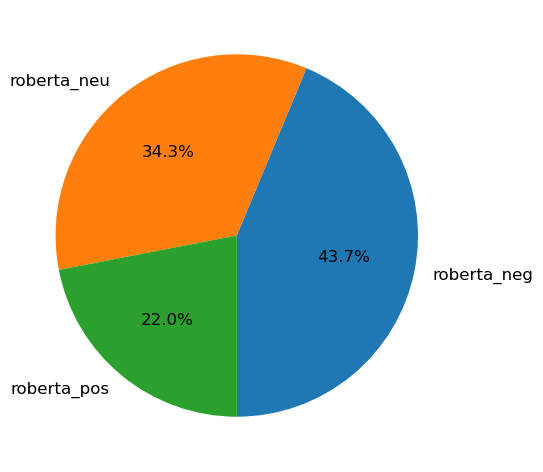

In [238]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")